# Goal

* Run `vegan::betadisper()` on beta-div distance matrices 
  * distances partitioned by taxonomic level
    * eg., `group` = class

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S/intra_host_variance/beta_div/'

# phyloseq of all taxa
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# distance matrices
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/beta_div.RDS'

# misc
threads = 4

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Load

In [4]:
metadata = readRDS(physeq_file) %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame
metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 171


,X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,wellplate_position_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,B12,4,120,18,18,NA,1,20,1,NA
X101.Horse,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,E8,16,344,160,160,NA,2,20,101,NA
X102.Kulan,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,E9,16,345,161,161,NA,2,20,102,NA


## Distance matrices

In [5]:
# load beta-diversity dist. matrices
beta_d = readRDS(beta_div_file)

# status
lapply(beta_d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


# Checks

In [6]:
# overlap
setdiff(labels(beta_d$weighted_unifrac), metadata$X.SampleID) %>% length %>% print
setdiff(metadata$X.SampleID, labels(beta_d$weighted_unifrac)) %>% length %>% print

[1] 0
[1] 0


# betadisper

## Functions

In [7]:
dist_mtx_order = function(d, x){
    # Ordering distance matrixes
    # d = distance matrix (dist class)
    # x = vector to order dist. obj. by
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

In [8]:
beta_disp = function(d, fac, samples){
    # checking beta dispersion
    d = dist_mtx_order(d, samples)
    ret = vegan::betadisper(d,fac)
    ret = data.frame(group = ret$group,         # note: group is in wrong order; but can just match host_subj_id based on sampleID
                     distances = ret$distances)
    return(ret)
}

In [9]:
format_data = function(x){
    # format output
    x = do.call(rbind, x) 
    x$metric = gsub('\\..+', '', rownames(x))
    x$sample_id = gsub('^.*?\\.', '', rownames(x))
    return(x)
}

In [10]:
.beta_disp_all = function(group, d, metadata, threads=2){
    doParallel::registerDoParallel(cores=threads)
    ret = plyr::llply(d, beta_disp, fac=metadata[,group], 
                      samples=rownames(metadata), .parallel=TRUE)
    ret = format_data(ret)
    ret$grouping = group %>% as.character
    return(ret)
}

beta_disp_all = function(list_of_dists, metadata, groups, threads=2){
    groups = as.list(groups)
    ret = lapply(groups, .beta_disp_all, d=list_of_dists, metadata=metadata, threads=threads)
    ret = do.call(rbind, ret)
    return(ret)
}

## Taxonomy

### Run

In [11]:
groups = c('host_subject_id', 'scientific_name', 'genus', 'family', 'order', 'class')
beta_disp_ret = beta_disp_all(beta_d, metadata, groups=groups, threads=threads)
beta_disp_ret %>% dfhead

[1] 5112    5


,group,distances,metric,sample_id,grouping
bray_curtis.X1.Eurasian.Beaver,1,0,bray_curtis,X1.Eurasian.Beaver,host_subject_id
bray_curtis.X101.Horse,101,0,bray_curtis,X101.Horse,host_subject_id
bray_curtis.X102.Kulan,102,0,bray_curtis,X102.Kulan,host_subject_id


### Plotting

In [12]:
# formatting
## renaming grouping
old_names = c('host_subject_id', 'scientific_name','genus', 'family', 'order', 'class')
new_names = c('Individual', 'Species','Genus', 'Family', 'Order', 'Class')
df = data.frame(old_names, new_names)
beta_disp_ret_j = beta_disp_ret %>%
    inner_join(df, c('grouping'='old_names')) %>%
    dplyr::select(-grouping) %>%
    rename('grouping' = new_names)
beta_disp_ret_j$grouping = factor(beta_disp_ret_j$grouping, levels=new_names)
## Distance metrics
old_names = c('jaccard', 'bray_curtis', 'unweighted_unifrac', 'weighted_unifrac')
new_names = c('Jaccard', 'Bray Curtis', 'Unweighted\nUnifrac', 'Weighted\nUnifrac')
df = data.frame(old_names, new_names)
beta_disp_ret_j = beta_disp_ret_j %>%
    inner_join(df, c('metric'='old_names')) %>%
    dplyr::select(-metric) %>%
    rename('metric' = new_names)
## filtering out any with just one in group
beta_disp_ret_j = beta_disp_ret_j %>%
    group_by(group, metric, grouping) %>%
    mutate(N_SAMP = n()) %>%
    ungroup() %>%
    filter(N_SAMP > 1) %>%
    mutate(metric = factor(metric, levels=new_names))

# status
beta_disp_ret_j %>% dfhead

Warning message:
“Column `grouping`/`old_names` joining character vector and factor, coercing into character vector”Warning message:
“Column `metric`/`old_names` joining character vector and factor, coercing into character vector”

[1] 3548    6


group,distances,sample_id,grouping,metric,N_SAMP
Equus_caballus,0.4020212,X101.Horse,Species,Bray Curtis,3
Equus_hemionus,0.6605829,X102.Kulan,Species,Bray Curtis,4
Vulpes_vulpes,0.5000000,X109.Red.Fox,Species,Bray Curtis,2


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/2_intra_host_variance/2_beta_div/.figures/betadisper_diet_all-dist_tax-lev.pdf 


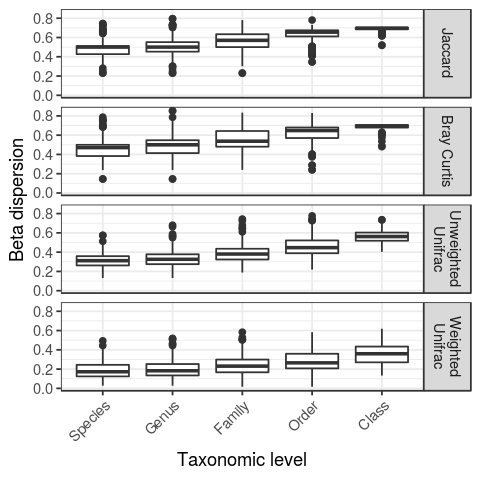

In [13]:
# plotting
p = ggplot(beta_disp_ret_j, aes(grouping, distances)) +
    geom_boxplot() +
    labs(x='Taxonomic level', y='Beta dispersion') +
    facet_grid(metric ~ .) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=4, repr.plot.height=4)
plot_write(p, file='betadisper_diet_all-dist_tax-lev.pdf')

## Diet

In [14]:
groups = c('diet', 'diet_detail', 'digestive_system', 'digestive_system_detail')
beta_disp_ret = beta_disp_all(beta_d, metadata, groups=groups, threads=threads)
beta_disp_ret %>% dfhead

[1] 2260    5


,group,distances,metric,sample_id,grouping
bray_curtis.X1.Eurasian.Beaver,herbivore,0.7220295,bray_curtis,X1.Eurasian.Beaver,diet
bray_curtis.X101.Horse,herbivore,0.7029417,bray_curtis,X101.Horse,diet
bray_curtis.X102.Kulan,herbivore,0.6772546,bray_curtis,X102.Kulan,diet


In [15]:
# formatting
## renaming grouping
old_names = c('diet', 'diet_detail', 'digestive_system', 'digestive_system_detail')
new_names = c('Diet', 'Diet Detail', 'Digestive System', 'Digestive System Detail')
df = data.frame(old_names, new_names)
beta_disp_ret_j = beta_disp_ret %>%
    inner_join(df, c('grouping'='old_names')) %>%
    dplyr::select(-grouping) %>%
    rename('grouping' = new_names)
beta_disp_ret_j$grouping = factor(beta_disp_ret_j$grouping, levels=new_names)
## Distance metrics
old_names = c('jaccard', 'bray_curtis', 'unweighted_unifrac', 'weighted_unifrac')
new_names = c('Jaccard', 'Bray Curtis', 'Unweighted\nUnifrac', 'Weighted\nUnifrac')
df = data.frame(old_names, new_names)
beta_disp_ret_j = beta_disp_ret_j %>%
    inner_join(df, c('metric'='old_names')) %>%
    dplyr::select(-metric) %>%
    rename('metric' = new_names)
## filtering out any with just one in group
beta_disp_ret_j = beta_disp_ret_j %>%
    group_by(group, metric, grouping) %>%
    mutate(N_SAMP = n()) %>%
    ungroup() %>%
    filter(N_SAMP > 1) %>%
    mutate(metric = factor(metric, levels=new_names))

# status
beta_disp_ret_j %>% dfhead

Warning message:
“Column `grouping`/`old_names` joining character vector and factor, coercing into character vector”Warning message:
“Column `metric`/`old_names` joining character vector and factor, coercing into character vector”

[1] 2240    6


group,distances,sample_id,grouping,metric,N_SAMP
herbivore,0.7220295,X1.Eurasian.Beaver,Diet,Bray Curtis,87
herbivore,0.7029417,X101.Horse,Diet,Bray Curtis,87
herbivore,0.6772546,X102.Kulan,Diet,Bray Curtis,87


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/2_intra_host_variance/2_beta_div/.figures/betadisper_diet_all-dist_diet.pdf 


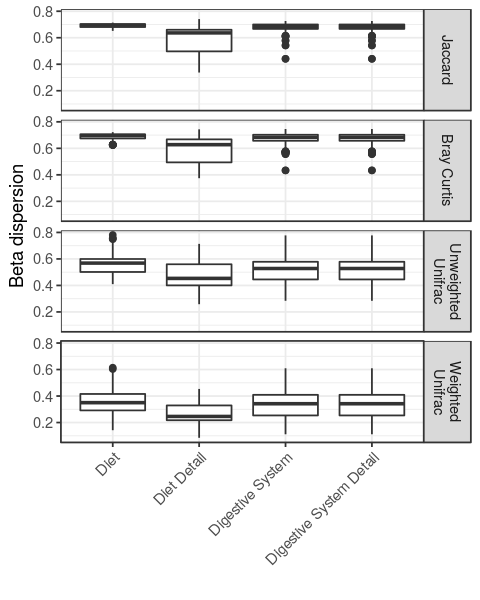

In [16]:
# plotting
p = ggplot(beta_disp_ret_j, aes(grouping, distances)) +
    geom_boxplot() +
    labs(x='', y='Beta dispersion') +
    facet_grid(metric ~ .) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=4, repr.plot.height=5)
plot_write(p, file='betadisper_diet_all-dist_diet.pdf')

# SessionInfo

In [17]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2  phyloseq_1.22.3 ggplot2_3.0.0   tidyr_0.8.1    
[5] dplyr_0.7.6    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17        ape_5.1             lattice_0.20-34    
 [4] Biostrings_2.46.0   assertthat_0.2.0    digest_0.6.15      
 [7] foreach_1.4.4       IRdisplay_0.4.4     R6_2.2.2           
[10] plyr_1.8.4          repr_0.15.0         stats4_3.4.1       
[13] evaluate_0.10.1     pillar_1.2.2        zlibbioc_1.24.0    
[16] rlang_0.2.1         lazyeval_0.2.1      uuid_0.1-2         
[19] data.table_